In [1]:
import pandas as pd
from dangerous_driving import DangerousDrivingDetection
from driving_event import DrivingEventDetection
from pykalman import KalmanFilter

###### Constants

In [2]:
N_CLUSTERS = 3
LABEL_PATH = "./safety/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv"
FEATURES_PATHS = ["./safety/features/part-0000{}-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv".format(i) for i in range(10)]
WINDOW_SIZE = 3

###### Datas

In [3]:
dtypes_dict = {'bookingID': str}
label = pd.read_csv(LABEL_PATH, dtype=dtypes_dict)
features = pd.concat([pd.read_csv(f, dtype=dtypes_dict) for f in FEATURES_PATHS]).sort_values("second").groupby("bookingID")

# Driving Event Detection

###### Data

In [4]:
longest_trip_id = features.size().sort_values(ascending=False).head(1).index.values[0]
driving_event_features = features.get_group(longest_trip_id)

In [5]:
driving_event = DrivingEventDetection(driving_event_features)

In [6]:
driving_event.data.head(10)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
688080,438086664371,4.0,351.0,0.339977,10.928333,1.784877,0.011484,0.070017,-0.096468,0.0,7.340000
1554664,438086664371,4.0,351.0,-0.873884,9.346964,2.134431,0.329745,0.332689,-0.191152,1.0,9.540000
1038426,438086664371,4.0,352.0,0.902614,9.793482,2.266112,-0.014172,0.005877,0.015321,2.0,9.700000
746317,438086664371,4.0,352.0,-0.244209,9.490616,0.541090,-0.038607,0.007098,0.002492,3.0,9.440000
77421,438086664371,4.0,350.0,-0.547075,9.014170,-3.253720,0.074403,-0.085753,0.128331,4.0,9.420000
992307,438086664371,5.0,350.0,-0.480037,8.300697,-1.753753,-0.012339,-0.033219,0.021429,5.0,8.990000
400858,438086664371,5.0,350.0,1.100136,9.385271,-0.304064,0.113499,-0.099803,0.129552,6.0,10.490000
624754,438086664371,5.0,349.0,-0.507571,10.576386,4.575319,-0.126571,0.020537,0.031203,7.0,11.090000
1336458,438086664371,5.0,347.0,0.772130,10.296265,4.357447,-0.022113,0.040696,-0.054318,8.0,10.290000
300509,438086664371,5.0,346.0,1.626860,10.843340,6.062118,-0.482095,-0.354534,0.230956,9.0,9.139999


### Feature Selection

Since longitudinal and lateral motion of the vehicle are determined by Y axis linear acceleration and Z axis angular acceleration, we will use those features

In [7]:
driving_event.set_data(driving_event.data.loc[:, ["acceleration_y", "gyro_z", "second"]])

### Pre Processing

We'll use kalman filter to reduce noise in the data

In [8]:
def kalman_filter(dataframe, column):
    kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
    measurement = dataframe[column].values
    mean, variance = kf.em(measurement, n_iter=5).filter(measurement)
    return mean

In [9]:
driving_event.pre_process("new_acc_y", lambda x: kalman_filter(x, "acceleration_y"))
driving_event.pre_process("new_gyro_z", lambda x: kalman_filter(x, "gyro_z"))

In [10]:
driving_event.data.plot.line(x="second", y=["acceleration_y", "new_acc_y"])

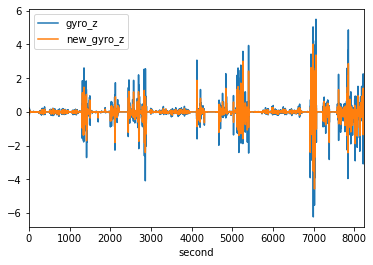

In [11]:
driving_event.data.plot.line(x="second", y=["gyro_z", "new_gyro_z"])

### Feature Extraction

##### Sliding Window

Most events that happen during driving (speed control, steady driving, hard turn, etc) take time more than 1 second. However, the dataset only give us the acceleration per 1 second. That's why we need to fetch data every N seconds and summarize it. The N here is 3 seconds

The statistical feature that will be used per window is variance. Mean, variance, and IQR have been tested and combined with each other and variance has the best silhouette score during clustering.

In [12]:
def get_variance_of_window(dataframe, column, window_size):
    return dataframe[column].rolling(window_size).var()

In [13]:
cluster_data = driving_event.get_learning_features(lambda x: get_variance_of_window(x, ["new_acc_y", "new_gyro_z"], 
                                                                                      WINDOW_SIZE)) 

In [14]:
driving_event.set_data(cluster_data.dropna())

In [15]:
driving_event.data.head(10)

,new_acc_y,new_gyro_z
1038426,0.014641,0.002472
746317,0.013290,0.004703
77421,0.039671,0.003986
992307,0.183043,0.002076
400858,0.078251,0.000746
624754,0.408004,0.000791
1336458,0.313633,0.002937
300509,0.093557,0.005573
1252501,0.060250,0.006245
907867,0.074641,0.011494


### Clustering

##### Scaling with Standard Scaler

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
driving_event.scale_data(StandardScaler())

#### Training

I choose 3 clusters since it has the biggest silhouette score than others

In [18]:
%matplotlib inline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

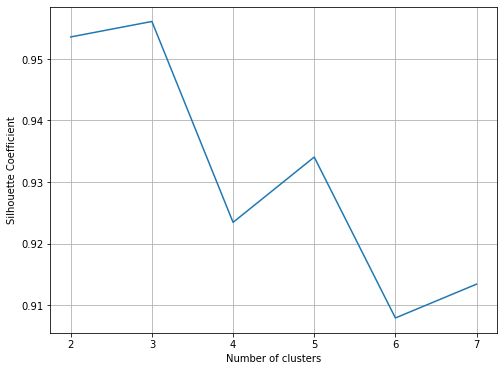

In [19]:
try_range = range(2, 8)
try_models = [KMeans(n_clusters=i, random_state=1, tol=1e-8) for i in try_range]
scores = []
plt.figure(figsize=(8,6))

for m in try_models:
    model = driving_event.train(m)
    scores.append(metrics.silhouette_score(driving_event.data, model.labels_))

plt.plot(try_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

According to this plot, 3 clusters will give the best clustering result (measured by silhouette score)

In [20]:
km = KMeans(n_clusters=N_CLUSTERS, random_state=1, tol=1e-8)
km = driving_event.train(km)

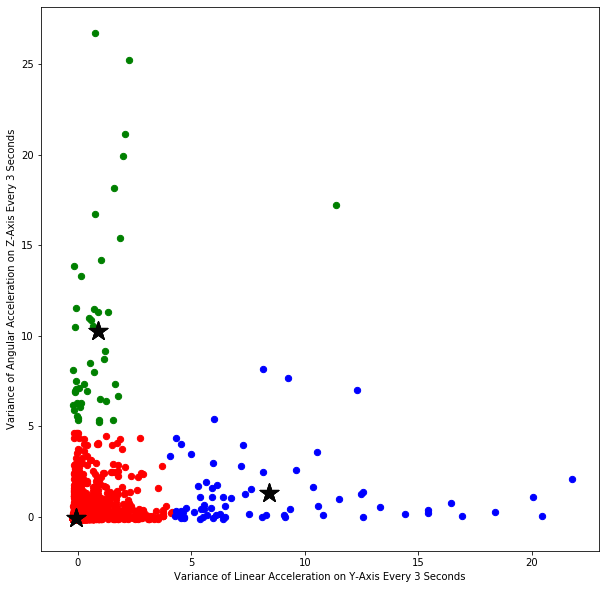

In [21]:
colors = ['r', 'g', 'b']
plt.figure(figsize=(10,10))
k = N_CLUSTERS
x_arr = driving_event.data
labels = km.labels_
centroids = km.cluster_centers_
for i in range(k):
    points = np.array([x_arr[j] for j in range(len(driving_event.data)) if labels[j] == i])
    plt.scatter(points[:, 0], points[:, 1], s=40, c=colors[i])
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=400,
                c='#050505')

plt.xlabel("Variance of Linear Acceleration on Y-Axis Every 3 Seconds")
plt.ylabel("Variance of Angular Acceleration on Z-Axis Every 3 Seconds")
plt.show()

# Dangerous Driving Detection

We'll use the KMeans model to detect events that occured in any trips. These events will be counted and the number of the events will be fed to the classifier. The steps for these task are pretty much the same as the driving event detection, except that we're working with groups now rather than a dataframe.

In [247]:
danger_driving = DangerousDrivingDetection(features)

##### Feature Extraction

We'll use the same method as the previous one, which is sliding window

In [23]:
def add_feature_for_group(features, group_name, labels, counts):
    features_dict = {'bookingID': group_name, **dict(zip(labels, counts))}
    for k in features:
        if k not in features_dict:
            features_dict[k] = 0
        features[k].append(features_dict[k])
    return features

In [24]:
def count_events(groups, columns, window_size):
    features = {'bookingID': [], **{i: [] for i in range(N_CLUSTERS)}}
    for name, group in groups:
        window_var = get_variance_of_window(group, columns, window_size).dropna()
        ss = StandardScaler()
        cluster_data = ss.fit_transform(window_var)
        events = km.predict(cluster_data)
        
        labels, counts = np.unique(events, return_counts=True)
        features = add_feature_for_group(features, name, labels, counts)
    return pd.DataFrame.from_dict(features)

In [248]:
danger_driving.set_data(danger_driving.get_learning_features(lambda x: count_events(x, ["acceleration_y", "gyro_z"], 
                                                                                              WINDOW_SIZE)))

In [249]:
danger_driving.merge_label_to_data(label, on="bookingID")
danger_driving.drop_column("bookingID")

###### Training

We'll use Multi Layer Perceptron Classifier

In [27]:
from sklearn.model_selection import train_test_split

In [250]:
x, y = danger_driving.split_feature_and_label("label")

In [251]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [252]:
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.fit_transform(x_test)

In [253]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

In [321]:
ann = MLPClassifier(hidden_layer_sizes=(3, ), alpha=0.001, random_state=42, learning_rate_init=0.01)

In [322]:
ann.fit(x_train, y_train)

MLPClassifier(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(3,), learning_rate='constant',
              learning_rate_init=0.01, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=42, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [323]:
ann.score(x_test, y_test)

0.7590742590742591

###### Evaluation

In [257]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [290]:
y_pred = ann.predict(x_test)

In [259]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [292]:
cm = confusion_matrix(y_test, y_pred)

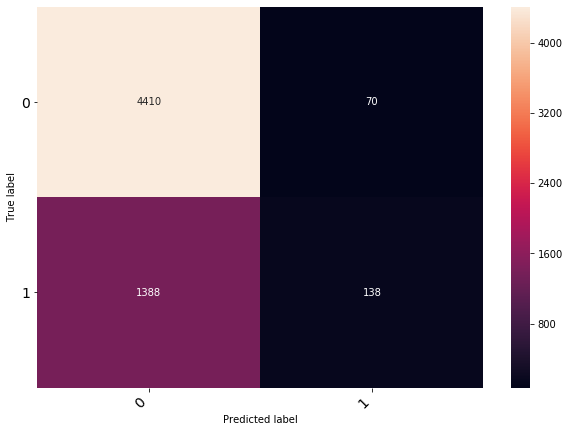

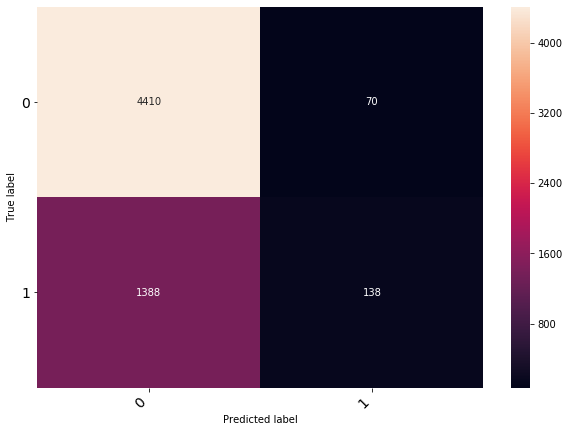

In [293]:
print_confusion_matrix(cm, ['0', '1'])